In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')

import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

# 이상치 제거 함수

In [219]:
def get_outlier(df=None, column=None, weight=1.5):
    import numpy as np
    age_group_list = [20,30,40,50,60,70]
    outlier_index_set = set()
    
    
    for age_group in age_group_list:
        # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
        fraud = df[df['연령대_1']==age_group][column]
        quantile_25 = np.percentile(fraud.values, 25)
        quantile_75 = np.percentile(fraud.values, 75)
        iqr = quantile_75 - quantile_25
        iqr_weight = iqr * weight
        lowest_val = quantile_25 - iqr_weight
        highest_val = quantile_75 + iqr_weight
        # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
        outlier_index_set = outlier_index_set | set(fraud[(fraud < lowest_val) | (fraud > highest_val)].index)
        
    return outlier_index_set

def remove_outlier(df=None,column_list=None,weight=1.5):
    outlier_index_set = set()
    
    for column_name in column_list:
        outlier_index = get_outlier(df=df, column=column_name, weight=weight)
        outlier_index_set = outlier_index_set | outlier_index
        
    df.drop(list(outlier_index_set), inplace=True)
    df.reset_index(drop=True, inplace=True)


# 통신데이터 컬럼 드랍 및 데이터 프레임 만들기

In [220]:
for m in tqdm(range(1,10),desc='월단위 진행'):
    globals()["ts{}".format(m)] = pd.read_csv(f'./data/2022.{m}월_29개 통신정보.csv',encoding='cp949')
    try : 
        globals()["ts{}".format(m)].drop(columns=['행정동코드','행정동','총인구수','1인가구수'],inplace=True)    
    except:
        globals()["ts{}".format(m)].drop(columns=['행정동코드','행정동명','총인구','1인가구수'],inplace=True)  
    globals()["ts{}".format(m)].drop(columns=globals()["ts{}".format(m)].filter(like='4분위수'),inplace=True)
    globals()["ts{}".format(m)].drop(columns=globals()["ts{}".format(m)].filter(like='인구'),inplace=True) #미추정
    
    # 데이터가 평균값을 제시하고 그 외 4분위 관련 수치를 따로 제공해주고 있음 -> 이미 전처리가 되어있는 거 같음..?
    globals()["ts{}".format(m)]['연령대_1'] = globals()["ts{}".format(m)]['연령대']//10*10
    globals()["ts{}".format(m)]['월'] = int(m)
    fix = globals()["ts{}".format(m)][['월','연령대','연령대_1','자치구','성별']]
    uni = ['상주지','출근','근무','소액결재','연체','카카오톡','SNS','통화','문자','데이터','이동','체류','지하철','게임','금융','쇼핑','동영상','유튜브','넷플릭스','배달']
    
    for col in tqdm(uni,desc=f'{m}월'):
        globals()["{}_{}".format(col,m)] = pd.concat([fix,globals()["ts{}".format(m)].filter(like=col)],axis=1)    
        
        
for col in tqdm(uni,desc='카테고리별로 합치기'):
    globals()["{}".format(col)] = pd.DataFrame()
    for m in range(1,10):
        globals()["이동_{}".format(m)].drop(columns= globals()["이동_{}".format(m)].filter(like='지하철'),inplace=True)
        globals()["{}".format(col)]= pd.concat([globals()["{}".format(col)],globals()["{}_{}".format(col,m)]])

월단위 진행:   0%|          | 0/9 [00:00<?, ?it/s]

1월:   0%|          | 0/20 [00:00<?, ?it/s]

2월:   0%|          | 0/20 [00:00<?, ?it/s]

3월:   0%|          | 0/20 [00:00<?, ?it/s]

4월:   0%|          | 0/20 [00:00<?, ?it/s]

5월:   0%|          | 0/20 [00:00<?, ?it/s]

6월:   0%|          | 0/20 [00:00<?, ?it/s]

7월:   0%|          | 0/20 [00:00<?, ?it/s]

8월:   0%|          | 0/20 [00:00<?, ?it/s]

9월:   0%|          | 0/20 [00:00<?, ?it/s]

카테고리별로 합치기:   0%|          | 0/20 [00:00<?, ?it/s]

In [221]:
df = pd.concat([ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9],axis=0,ignore_index=True)
df258 = pd.concat([ts2,ts5,ts8],ignore_index=True)
# df

In [210]:
df = df[['자치구', '성별', '연령대', '연령대_1', '월', '야간상주지 변경횟수 평균',
       '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균', '평균 근무시간 평균', '소액결재 사용횟수 평균',
       '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율', 'SNS 사용횟수', '평균 통화량', '평균 문자량',
       '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량', '평일 총 이동 횟수', '휴일 총 이동 횟수 평균',
       '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간', '평일 총 이동 거리 합계',
       '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수', '금융 서비스 사용일수',
       '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수', '넷플릭스 사용일수',
       '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수']]

In [222]:
# df.to_csv('./data_2/ts_all.csv',index=False)
df258.to_csv('./data_2/ts_258.csv',index=False)

In [212]:
df.shape

(91584, 34)

# 전처리

## 이상치 제거

In [224]:
col_lst = df.columns[5:]
col_= [x for x in col_lst ]
# col_

# remove_outlier(df,col_)
remove_outlier(df258,col_)

# df

In [215]:
df['연령대_1'].value_counts()

40    12037
30    12019
60    11333
70    10427
20     7963
50     7709
Name: 연령대_1, dtype: int64

In [225]:
# df.to_csv('./data_2/ts_outlier_done.csv',index=False)
df258.to_csv('./data_2/ts258_outlier_done.csv',index=False)

## 인코딩

In [174]:
X_num = ['야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균', '평균 근무시간 평균',
       '소액결재 사용횟수 평균', '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율', 'SNS 사용횟수',
       '평균 통화량', '평균 문자량', '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량', '평일 총 이동 횟수',
       '휴일 총 이동 횟수 평균', '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간',
       '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수',
       '금융 서비스 사용일수', '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수',
        '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수']
X_cat = ['성별']


In [147]:
# from sklearn.preprocessing import label_binarize
# test = df.drop(columns=['자치구','월','연령대'])
# X=test.drop(columns='연령대_1')
# y = test['연령대_1']
# y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
# n_classes = y.shape[1]

In [192]:
test = df.drop(columns=['자치구','월','연령대'])
X=test.drop(columns='연령대_1')
y = test[['연령대_1']]


# #연령 인코딩 해주기
# le = LabelEncoder()
# y = le.fit_transform(y['연령대_1'])
# # print(le.classes_)

# # 성별 인코딩 해주기 
# le = LabelEncoder()
# X['성별'] = le.fit_transform(X['성별'])
# # print(le.classes_)

In [148]:
# test = df.drop(columns=['자치구','월','연령대'])
# y = test[['연령대_1']]
# X = test.drop(columns='연령대_1')
# X = pd.get_dummies(X,columns=['성별'])
# X

# y = test[['연령대_1']]
# y = pd.get_dummies(y['연령대_1'])
# y

## 스케일링

In [185]:
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=11)

In [186]:
scaler = StandardScaler()
X_train[X_num] = scaler.fit_transform(X_train[X_num])
X_test[X_num] = scaler.transform(X_test[X_num])


# 변수 선정

In [213]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9,15],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)
final_model = grid_search.best_estimator_
final_model


Fitting 5 folds for each of 108 candidates, totalling 540 fits


DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=15,
                       max_features='auto', random_state=1024)

0.947
0.942


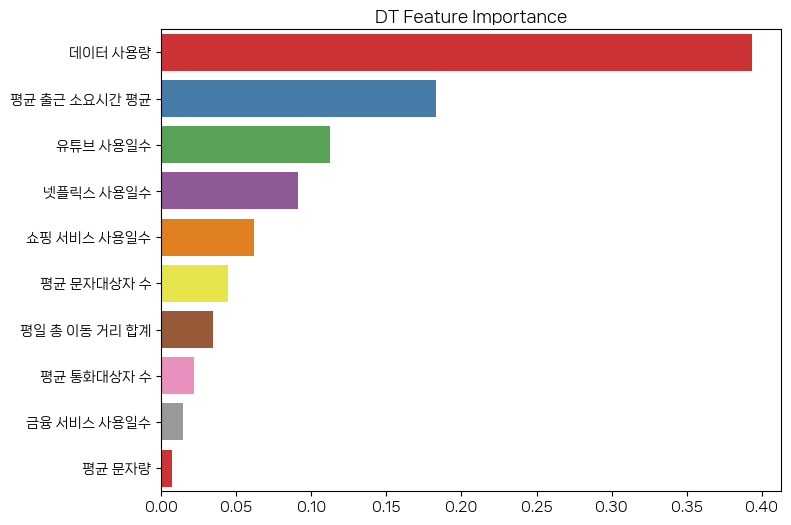

In [12]:
tree = DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=15,
                       max_features='auto', random_state=1024)
# tree = DecisionTreeClassifier(random_state=1024)
tree.fit(X_train,y_train)
score_tr = tree.score(X_train,y_train)
score_te = tree.score(X_test,y_test)

print('{:.3f}'.format(score_tr))
# 1.000
print('{:.3f}'.format(score_te))

feature_imp = tree.feature_importances_

dt_seires= pd.Series(feature_imp,index=X_train.columns)
dt_top10=dt_seires.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('DT Feature Importance')
sns.barplot(x=dt_top10,y=dt_top10.index,palette='Set1')
plt.show()


In [14]:
dt_feature = pd.DataFrame(dt_top10,columns=['Top10 DT Feature Importances'])
dt_feature

,Top10 DT Feature Importances
데이터 사용량,0.393190
평균 출근 소요시간 평균,0.182879
유튜브 사용일수,0.112275
넷플릭스 사용일수,0.090908
쇼핑 서비스 사용일수,0.061768
평균 문자대상자 수,0.044545
평일 총 이동 거리 합계,0.034319
평균 통화대상자 수,0.021578
금융 서비스 사용일수,0.014697
평균 문자량,0.007000


In [ ]:
param_grid = {#'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy'],
              'n_estimators':[10,20,30,40]
             }
tree_clas = RandomForestClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)
final_model = grid_search.best_estimator_
final_model


0.987
0.984


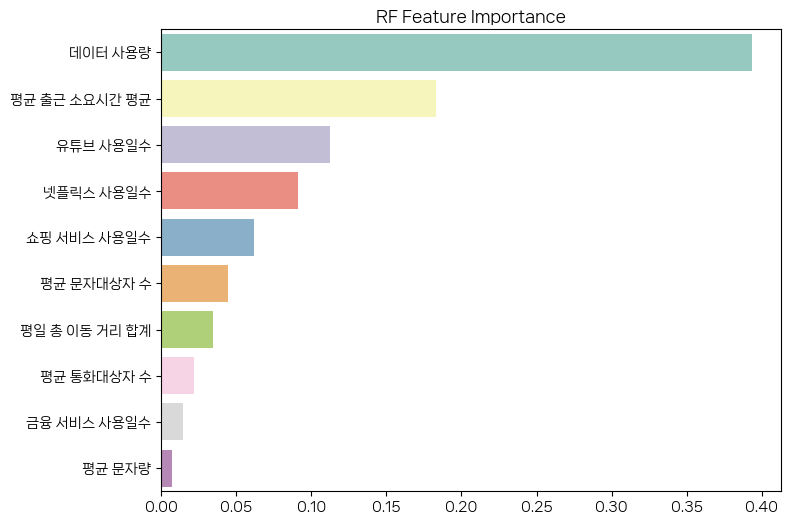

In [216]:
# tree = RandomForestClassifier(max_depth=9, n_estimators=90, random_state=1024)
tree = RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=40,
                       random_state=1024)

tree.fit(X_train,y_train)
score_tr = tree.score(X_train,y_train)
score_te = tree.score(X_test,y_test)

print('{:.3f}'.format(score_tr))
# 1.000
print('{:.3f}'.format(score_te))


feature_imp = tree.feature_importances_

rf_seires= pd.Series(feature_imp,index=X_train.columns)
rf_top10=dt_seires.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('RF Feature Importance')
sns.barplot(x=rf_top10,y=rf_top10.index,palette='Set3')
plt.show()


In [217]:
rf_feature = pd.DataFrame(rf_top10,columns=['Top10 RF Feature Importances'])
rf_feature

,Top10 RF Feature Importances
데이터 사용량,0.393190
평균 출근 소요시간 평균,0.182879
유튜브 사용일수,0.112275
넷플릭스 사용일수,0.090908
쇼핑 서비스 사용일수,0.061768
평균 문자대상자 수,0.044545
평일 총 이동 거리 합계,0.034319
평균 통화대상자 수,0.021578
금융 서비스 사용일수,0.014697
평균 문자량,0.007000


In [ ]:

# xg_parameters ={'max_depth' : [3,4,5,6] , 'n_estimators': [12,24,32], 'learning_rate':[0.01, 0.1], 'gamma': [0.5, 1, 2]}
# xg = XGBClassifier()
# grid_search_xg = GridSearchCV ( estimator = xg, param_grid = xg_parameters, scoring = 'recall', cv = 10 )
# grid_search_xg.fit(X_train, y_train)
# best_xg = grid_search_xg.best_estimator_
# best_xg


[09:30:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

0.982
0.979


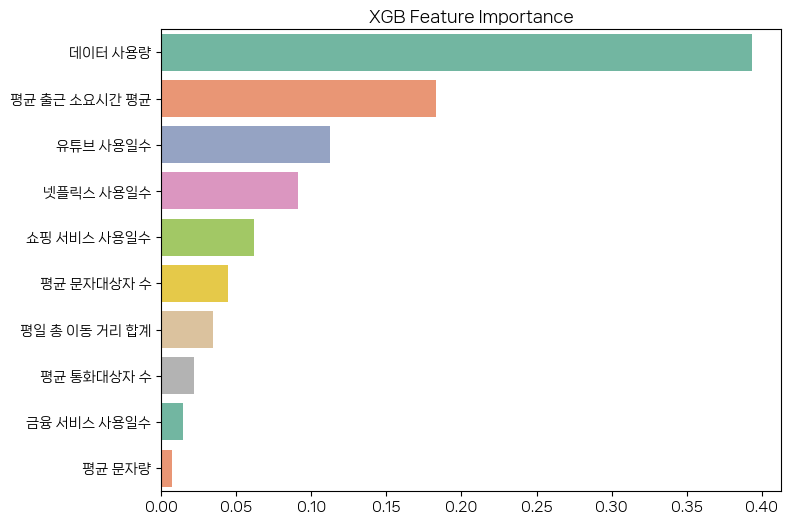

In [218]:
import xgboost
from xgboost import XGBClassifier
xg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=24, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=99,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# reg_alpha=1

# xg = XGBClassifier()
xg.fit(X_train,y_train)
score_tr = xg.score(X_train,y_train)
score_te = xg.score(X_test,y_test)
print('{:.3f}'.format(score_tr))
# 1.000
print('{:.3f}'.format(score_te))
feature_imp =xg.feature_importances_
xgb_seires= pd.Series(feature_imp,index=X_train.columns)
xgb_top10=dt_seires.sort_values(ascending=False)[:10]
plt.figure(figsize=(8,6))
plt.title('XGB Feature Importance')
sns.barplot(x=xgb_top10,y=xgb_top10.index,palette='Set2')
plt.show()

In [219]:
xgb_feature = pd.DataFrame(xgb_top10,columns=['Top10 XGB Feature Importances'])
xgb_feature

,Top10 XGB Feature Importances
데이터 사용량,0.393190
평균 출근 소요시간 평균,0.182879
유튜브 사용일수,0.112275
넷플릭스 사용일수,0.090908
쇼핑 서비스 사용일수,0.061768
평균 문자대상자 수,0.044545
평일 총 이동 거리 합계,0.034319
평균 통화대상자 수,0.021578
금융 서비스 사용일수,0.014697
평균 문자량,0.007000


In [220]:
pd.concat([dt_feature.reset_index(),rf_feature.reset_index(),xgb_feature.reset_index()],axis=1)

,index,Top10 DT Feature Importances,index,Top10 RF Feature Importances,index,Top10 XGB Feature Importances
0,데이터 사용량,0.393190,데이터 사용량,0.393190,데이터 사용량,0.393190
1,평균 출근 소요시간 평균,0.182879,평균 출근 소요시간 평균,0.182879,평균 출근 소요시간 평균,0.182879
2,유튜브 사용일수,0.112275,유튜브 사용일수,0.112275,유튜브 사용일수,0.112275
3,넷플릭스 사용일수,0.090908,넷플릭스 사용일수,0.090908,넷플릭스 사용일수,0.090908
4,쇼핑 서비스 사용일수,0.061768,쇼핑 서비스 사용일수,0.061768,쇼핑 서비스 사용일수,0.061768
5,평균 문자대상자 수,0.044545,평균 문자대상자 수,0.044545,평균 문자대상자 수,0.044545
6,평일 총 이동 거리 합계,0.034319,평일 총 이동 거리 합계,0.034319,평일 총 이동 거리 합계,0.034319
7,평균 통화대상자 수,0.021578,평균 통화대상자 수,0.021578,평균 통화대상자 수,0.021578
8,금융 서비스 사용일수,0.014697,금융 서비스 사용일수,0.014697,금융 서비스 사용일수,0.014697
9,평균 문자량,0.007000,평균 문자량,0.007000,평균 문자량,0.007000


# 모델링
[classification_repport](https://blog.naver.com/PostView.naver?blogId=hannaurora&logNo=222498671200&parentCategoryNo=&categoryNo=41&viewDate=&isShowPopularPosts=true&from=search)

In [193]:
# col_select = dt_feature.index.tolist()
col_select = ['데이터 사용량',
 '평균 출근 소요시간 평균',
 '유튜브 사용일수',
 '넷플릭스 사용일수',
 '쇼핑 서비스 사용일수',
 '평균 문자대상자 수',
 '평일 총 이동 거리 합계',
 '평균 통화대상자 수',
 '금융 서비스 사용일수',
 '평균 문자량']

col_select

['데이터 사용량',
 '평균 출근 소요시간 평균',
 '유튜브 사용일수',
 '넷플릭스 사용일수',
 '쇼핑 서비스 사용일수',
 '평균 문자대상자 수',
 '평일 총 이동 거리 합계',
 '평균 통화대상자 수',
 '금융 서비스 사용일수',
 '평균 문자량']

In [188]:
X_train = X_train[col_select]
X_test = X_test[col_select]

In [146]:
# params = { 'n_estimators' : [10, 100],
#            'max_depth' : [6, 8, 10, 12],
#            'min_samples_leaf' : [8, 12, 18],
#            'min_samples_split' : [8, 16, 20]
#             }

# # RandomForestClassifier 객체 생성 후 GridSearchCV 수행
# rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
# grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
# grid_cv.fit(X_train, y_train)

# print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
# print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

params = { 
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8}
최고 예측 정확도: 0.9726


In [151]:

dt = DecisionTreeClassifier(max_depth=12,min_samples_leaf=8,min_samples_split=8)
dt.fit(X_train,y_train)
pred_dt = dt.predict(X_test)
pred_proba_dt = dt.predict_proba(X_test)

# rf = RandomForestClassifier()
# rf.fit(X_train,y_train)
# pred_rf = rf.predict(X_test)
# pred_proba_rf = rf.predict_proba(X_test)

# xgb= XGBClassifier()
# xgb.fit(X_train,y_train)
# pred_xgb = xgb.predict(X_test)
# pred_proba_xgb = xgb.predict_proba(X_test)


# print(f'=== 분류 모형 성능 평가 ===')
print(f'DT accuracy : {accuracy_score(y_test,pred_dt)} \nDT f1(macro) : {f1_score(y_test,pred_dt,average="macro")} \nDT logloss : {log_loss(y_test,pred_proba_dt)}\n')
# print(f'RF accuracy : {accuracy_score(y_test,pred_rf)} \nRF f1(macro) : {f1_score(y_test,pred_rf,average="macro")} \nRF logloss : {log_loss(y_test,pred_proba_rf)}\n')
# print(f'XGB accuracy : {accuracy_score(y_test,pred_xgb)} \nRF f1(macro) : {f1_score(y_test,pred_xgb,average="macro")} \nRF logloss : {log_loss(y_test,pred_proba_xgb)}\n')


# print(classification_report(y_test,pred_rf))

DT accuracy : 0.9625955439908929 
DT f1(macro) : 0.9633904670642801 
DT logloss : 0.2512436998671298

